

# Задание 1



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

cuda




> *Скачайте датасет Fashion MNIST...*



In [ ]:
transform = transforms.ToTensor()

train_val_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(len(train_val_dataset), len(test_dataset))

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 193kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.52MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.7MB/s]

60000 10000


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



> *...посмотрите на картинки...*



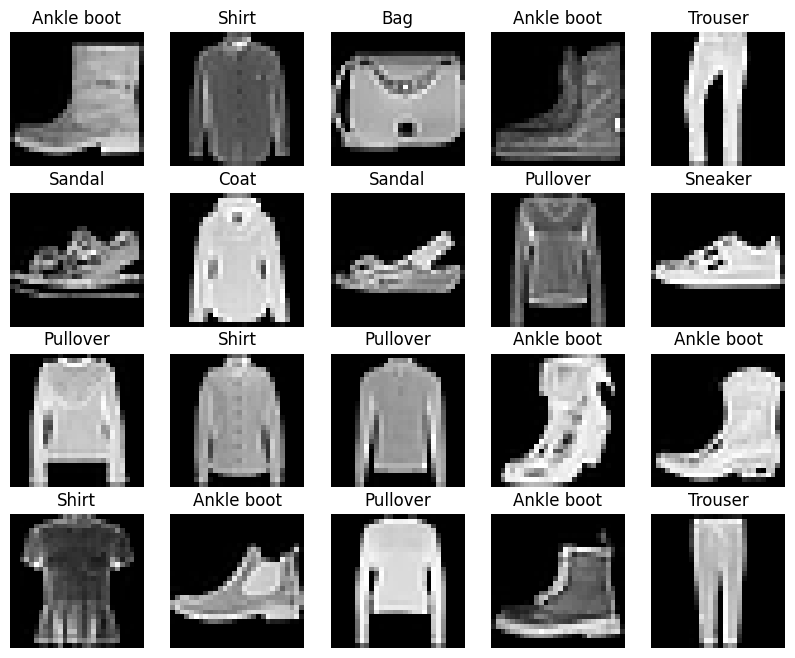

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols,rows = 5, 4

for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_val_dataset), size=(1,)).item()
  img, label = train_val_dataset[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(class_names[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

> *отделите валидационную выборку*

In [ ]:
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

print(train_size, val_size)

48000 12000


In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class FashionMNIST_MLP(nn.Module):
  def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
    super(FashionMNIST_MLP, self).__init__()
    self.input_size = input_size
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, num_classes)
    )

  def forward(self, x):
    return self.layers(x)


model_mlp = FashionMNIST_MLP().to(device)
print(model_mlp)

FashionMNIST_MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


>*Выведите summary модели*

In [ ]:
from torchsummary import summary
summary(model_mlp, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


In [ ]:
def accuracy(preds, labels):
  _, preds = torch.max(preds, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_epoch(model, train_loader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  running_acc = 0.0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    preds = model(images)
    loss = criterion(preds, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_acc += accuracy(preds, labels).item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = running_acc / len(train_loader)

  return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
  model.eval()
  running_loss = 0.0
  running_acc = 0.0

  with torch.no_grad():
    for images,labels in val_loader:
      images,labels = images.to(device), labels.to(device)
      preds = model(images)
      loss = criterion(preds, labels)

      running_loss += loss.item()
      running_acc += accuracy(preds, labels).item()

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = running_acc / len(val_loader)

  return epoch_loss, epoch_acc

> *обучите одну полносвязную архитектуру*

In [ ]:
model_mlp = FashionMNIST_MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

num_epochs = 10
print("начало обучения...")
for epoch in range(num_epochs):
  train_loss, train_acc = train_epoch(model_mlp, train_loader, criterion, optimizer, device)
  val_loss, val_acc = validate(model_mlp, train_loader, criterion, device)

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

начало обучения...
Epoch [1/10], Train Loss: 0.5761, Train Acc: 0.7970, Val Loss: 0.4067, Val Acc: 0.8569
Epoch [2/10], Train Loss: 0.3972, Train Acc: 0.8580, Val Loss: 0.3499, Val Acc: 0.8768
Epoch [3/10], Train Loss: 0.3580, Train Acc: 0.8691, Val Loss: 0.3307, Val Acc: 0.8784
Epoch [4/10], Train Loss: 0.3303, Train Acc: 0.8792, Val Loss: 0.3199, Val Acc: 0.8823
Epoch [5/10], Train Loss: 0.3090, Train Acc: 0.8855, Val Loss: 0.2978, Val Acc: 0.8905
Epoch [6/10], Train Loss: 0.2918, Train Acc: 0.8919, Val Loss: 0.2637, Val Acc: 0.9015
Epoch [7/10], Train Loss: 0.2804, Train Acc: 0.8955, Val Loss: 0.2696, Val Acc: 0.9003
Epoch [8/10], Train Loss: 0.2689, Train Acc: 0.9011, Val Loss: 0.2509, Val Acc: 0.9050
Epoch [9/10], Train Loss: 0.2550, Train Acc: 0.9058, Val Loss: 0.2405, Val Acc: 0.9078
Epoch [10/10], Train Loss: 0.2474, Train Acc: 0.9072, Val Loss: 0.2181, Val Acc: 0.9196


> *посмотрите на графики обучения*

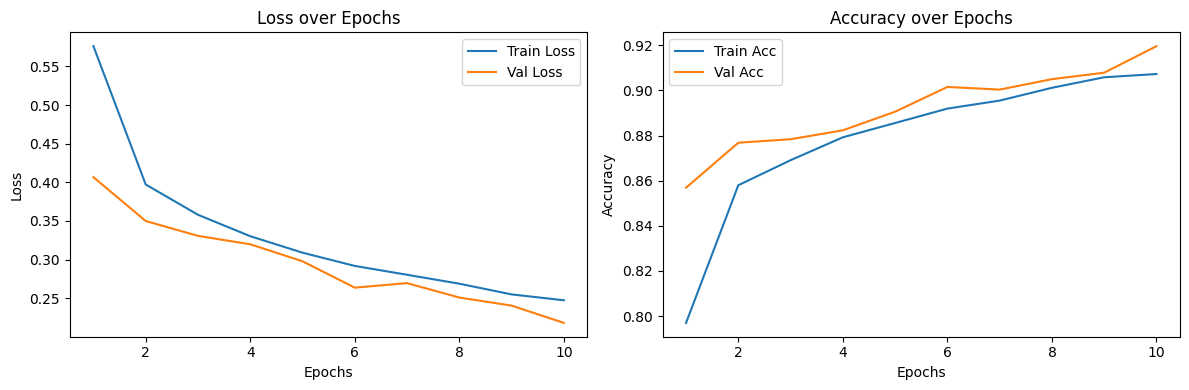

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Train Acc')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()

- Вывод

Модель хорошо справляется с обучением и стремится к уменьшению лосса

# Задание 2

In [ ]:
class FashionMNIST_CNN(nn.Module):
  def __init__(self, num_classes=10):
    super(FashionMNIST_CNN, self).__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
    )

    # полносвязные слои для классификации
    self.fc_layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64 * 7 * 7, 128),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(128, num_classes)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.fc_layers(x)
    return x

model_cnn = FashionMNIST_CNN().to(device)
print("CNN архитектура:")
print(model_cnn)

CNN архитектура:
FashionMNIST_CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
summary(model_cnn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 128]         401,536
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
model_cnn = FashionMNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

cnn_train_losses, cnn_val_losses = [], []
cnn_train_accs, cnn_val_accs = [], []

num_epochs = 10
print("начало обучения...")
for epoch in range(num_epochs):
  train_loss, train_acc = train_epoch(model_cnn, train_loader, criterion, optimizer, device)
  val_loss, val_acc = validate(model_cnn, val_loader, criterion, device)

  cnn_train_losses.append(train_loss)
  cnn_train_accs.append(train_acc)
  cnn_val_losses.append(val_loss)
  cnn_val_accs.append(val_acc)

  print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

начало обучения...
Epoch [1/10], Train Loss: 0.6184, Train Acc: 0.7750, Val Loss: 0.3598, Val Acc: 0.8670
Epoch [2/10], Train Loss: 0.3963, Train Acc: 0.8574, Val Loss: 0.3113, Val Acc: 0.8838
Epoch [3/10], Train Loss: 0.3395, Train Acc: 0.8778, Val Loss: 0.2791, Val Acc: 0.8961
Epoch [4/10], Train Loss: 0.3014, Train Acc: 0.8914, Val Loss: 0.2637, Val Acc: 0.9039
Epoch [5/10], Train Loss: 0.2753, Train Acc: 0.9002, Val Loss: 0.2595, Val Acc: 0.9048
Epoch [6/10], Train Loss: 0.2533, Train Acc: 0.9080, Val Loss: 0.2364, Val Acc: 0.9143
Epoch [7/10], Train Loss: 0.2338, Train Acc: 0.9154, Val Loss: 0.2481, Val Acc: 0.9111
Epoch [8/10], Train Loss: 0.2203, Train Acc: 0.9205, Val Loss: 0.2307, Val Acc: 0.9182
Epoch [9/10], Train Loss: 0.2061, Train Acc: 0.9249, Val Loss: 0.2299, Val Acc: 0.9210
Epoch [10/10], Train Loss: 0.1921, Train Acc: 0.9287, Val Loss: 0.2323, Val Acc: 0.9201


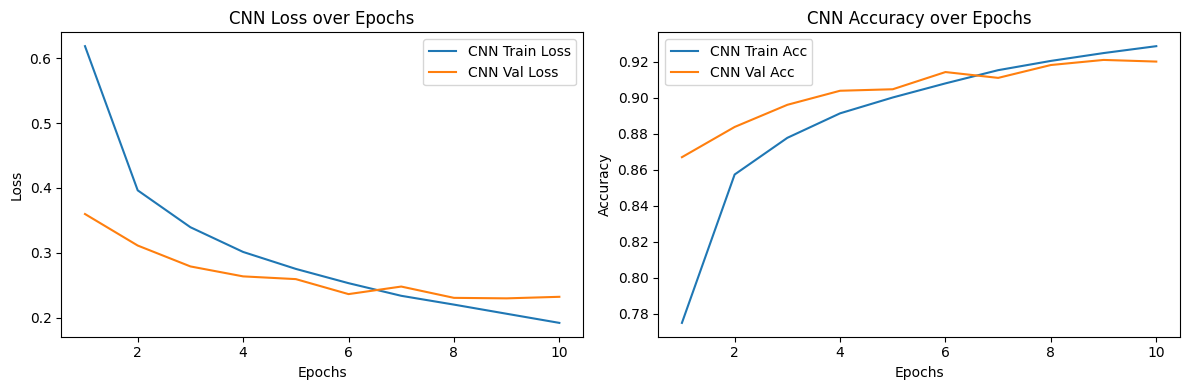

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), cnn_train_losses, label='CNN Train Loss')
plt.plot(range(1, num_epochs+1), cnn_val_losses, label='CNN Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), cnn_train_accs, label='CNN Train Acc')
plt.plot(range(1, num_epochs+1), cnn_val_accs, label='CNN Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Accuracy over Epochs')

plt.tight_layout()
plt.show()


=== СРАВНЕНИЕ МОДЕЛЕЙ ===
MLP - Финальная точность на валидации: 0.9196
CNN - Финальная точность на валидации: 0.9201


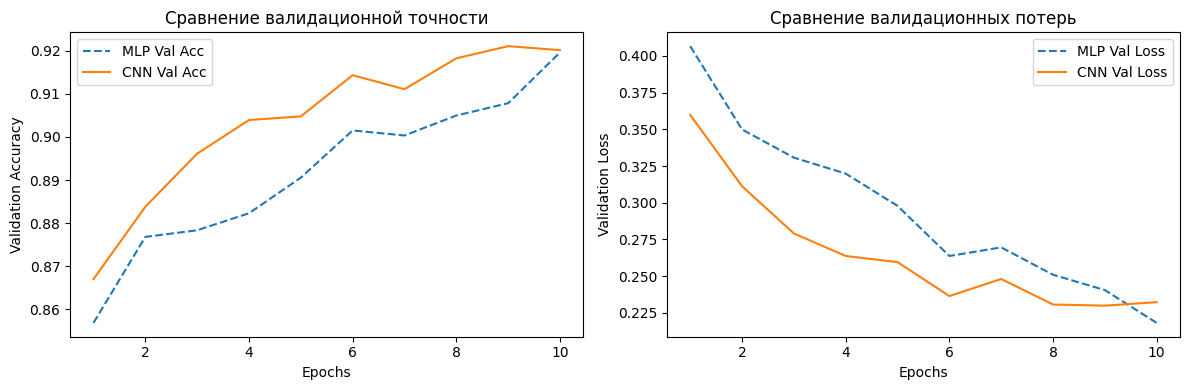

In [ ]:
print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
print(f"MLP - Финальная точность на валидации: {val_accs[-1]:.4f}")
print(f"CNN - Финальная точность на валидации: {cnn_val_accs[-1]:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), val_accs, label='MLP Val Acc', linestyle='--')
plt.plot(range(1, num_epochs+1), cnn_val_accs, label='CNN Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Сравнение валидационной точности')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_losses, label='MLP Val Loss', linestyle='--')
plt.plot(range(1, num_epochs+1), cnn_val_losses, label='CNN Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Сравнение валидационных потерь')

plt.tight_layout()
plt.show()

CNN и MLP модели хоть и имеют видимые различия в результатах в начале, но чем больше эпох, тем более похожими они становятся

# Задание 3

In [ ]:
# трансформация с аугментацией для тренировочных данных
train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(degrees=10),
  transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
  transforms.ToTensor(),
])

val_test_transform = transforms.ToTensor()

train_val_dataset_aug = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset_aug = datasets.FashionMNIST(root='./data', train=False, download=True, transform=val_test_transform)

train_dataset_aug, val_dataset_aug = random_split(train_val_dataset_aug, [train_size, val_size])

print(f"Размер тренировочной выборки с аугментацией: {len(train_dataset_aug)}")
print(f"Размер валидационной выборки: {len(val_dataset_aug)}")

train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=False)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=batch_size, shuffle=False)

Размер тренировочной выборки с аугментацией: 48000
Размер валидационной выборки: 12000


Одно исходное изображение с разными аугментациями:


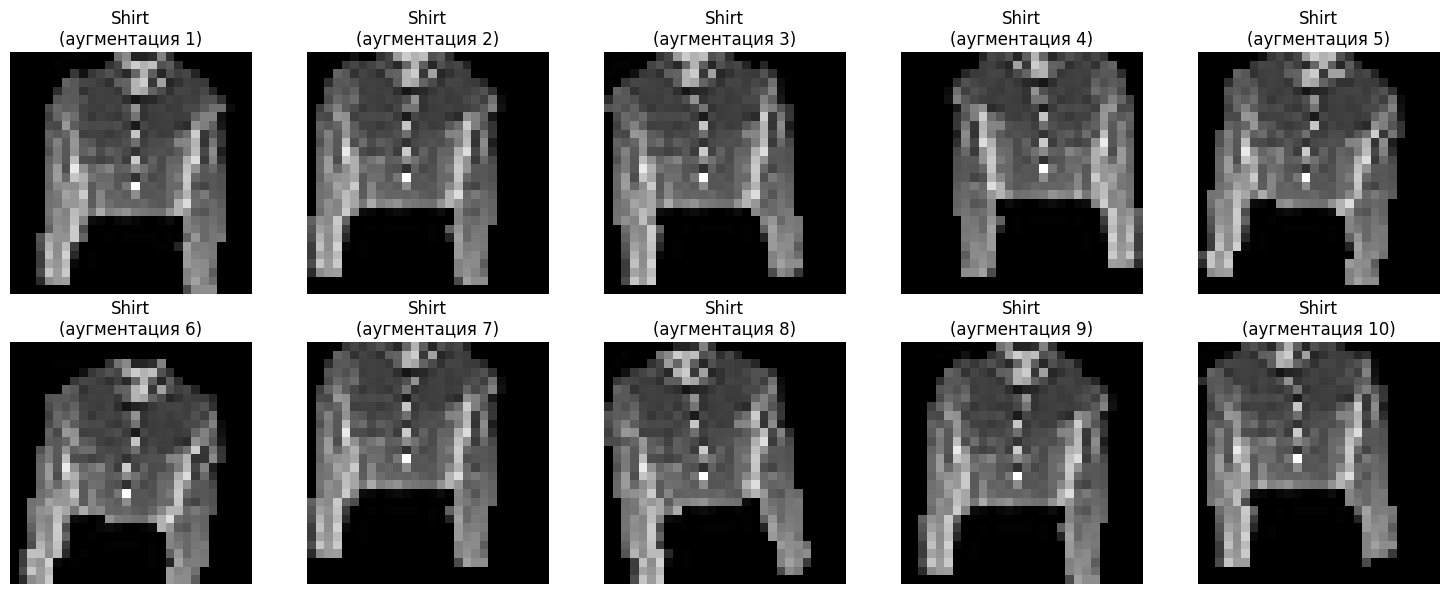


Разные аугментированные изображения:


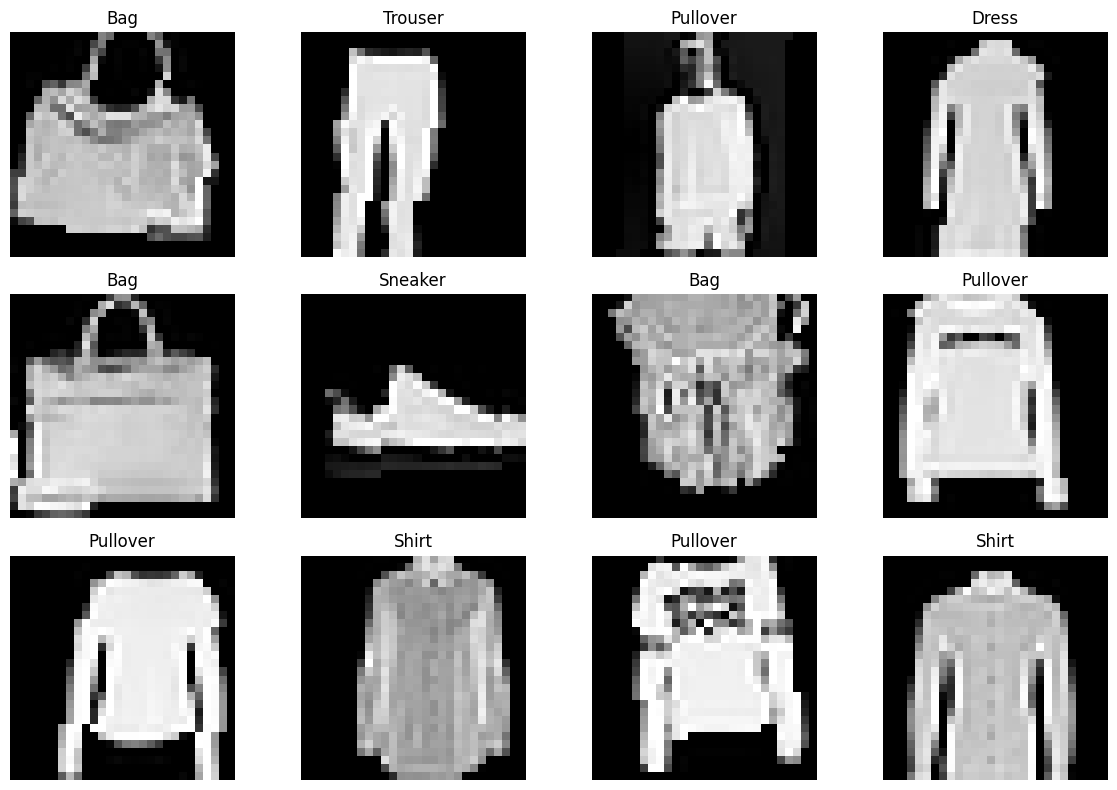

In [ ]:
def show_augmented_images(dataset, num_images=10):
  plt.figure(figsize=(15, 6))

  for i in range(num_images):
    img, label = dataset[0]

    plt.subplot(2, 5, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'{class_names[label]}\n(аугментация {i+1})')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

print("Одно исходное изображение с разными аугментациями:")
show_augmented_images(train_dataset_aug)

print("\nРазные аугментированные изображения:")
figure = plt.figure(figsize=(12, 8))
for i in range(12):
  idx = torch.randint(len(train_dataset_aug), size=(1,)).item()
  img, label = train_dataset_aug[idx]
  figure.add_subplot(3, 4, i+1)
  plt.title(class_names[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
# немного улучшенная модель для работы с аугментированными данными
class FashionMNIST_CNN_Enhanced(nn.Module):
  def __init__(self, num_classes=10):
    super(FashionMNIST_CNN_Enhanced, self).__init__()

    self.conv_layers = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.AdaptiveAvgPool2d((4, 4))
    )

    self.fc_layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(128 * 4 * 4, 256),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(128, num_classes)
    )

    self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.fc_layers(x)
    return x

model_enhanced = FashionMNIST_CNN_Enhanced().to(device)
print("Улучшенная CNN архитектура с BatchNorm:")
print(model_enhanced)

Улучшенная CNN архитектура с BatchNorm:
FashionMNIST_CNN_Enhanced(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): R

In [ ]:
summary(model_enhanced, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Conv2d-9            [-1, 128, 7, 7]          73,856
      BatchNorm2d-10            [-1, 128, 7, 7]             256
             ReLU-11            [-1, 128, 7, 7]               0
AdaptiveAvgPool2d-12            [-1, 128, 4, 4]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                  [

In [ ]:
model_aug = FashionMNIST_CNN_Enhanced().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001, weight_decay=1e-4)  # Добавим L2 регуляризацию

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

aug_train_losses, aug_val_losses = [], []
aug_train_accs, aug_val_accs = [], []

num_epochs = 15
print("начало обучения...")

for epoch in range(num_epochs):
  train_loss, train_acc = train_epoch(model_aug, train_loader_aug, criterion, optimizer, device)
  val_loss, val_acc = validate(model_aug, val_loader_aug, criterion, device)

  scheduler.step()
  current_lr = optimizer.param_groups[0]['lr']

  aug_train_losses.append(train_loss)
  aug_train_accs.append(train_acc)
  aug_val_losses.append(val_loss)
  aug_val_accs.append(val_acc)

  print(f'Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

начало обучения...
Epoch [1/15], LR: 0.001000, Train Loss: 0.7822, Train Acc: 0.7005, Val Loss: 0.5457, Val Acc: 0.7889
Epoch [2/15], LR: 0.001000, Train Loss: 0.5619, Train Acc: 0.7907, Val Loss: 0.4906, Val Acc: 0.8144
Epoch [3/15], LR: 0.001000, Train Loss: 0.4963, Train Acc: 0.8204, Val Loss: 0.4389, Val Acc: 0.8378
Epoch [4/15], LR: 0.001000, Train Loss: 0.4624, Train Acc: 0.8324, Val Loss: 0.4141, Val Acc: 0.8435
Epoch [5/15], LR: 0.000500, Train Loss: 0.4303, Train Acc: 0.8453, Val Loss: 0.3905, Val Acc: 0.8553
Epoch [6/15], LR: 0.000500, Train Loss: 0.3803, Train Acc: 0.8629, Val Loss: 0.3500, Val Acc: 0.8710
Epoch [7/15], LR: 0.000500, Train Loss: 0.3675, Train Acc: 0.8699, Val Loss: 0.3461, Val Acc: 0.8711
Epoch [8/15], LR: 0.000500, Train Loss: 0.3576, Train Acc: 0.8721, Val Loss: 0.3219, Val Acc: 0.8805
Epoch [9/15], LR: 0.000500, Train Loss: 0.3461, Train Acc: 0.8747, Val Loss: 0.3290, Val Acc: 0.8767
Epoch [10/15], LR: 0.000250, Train Loss: 0.3387, Train Acc: 0.8768, Val 

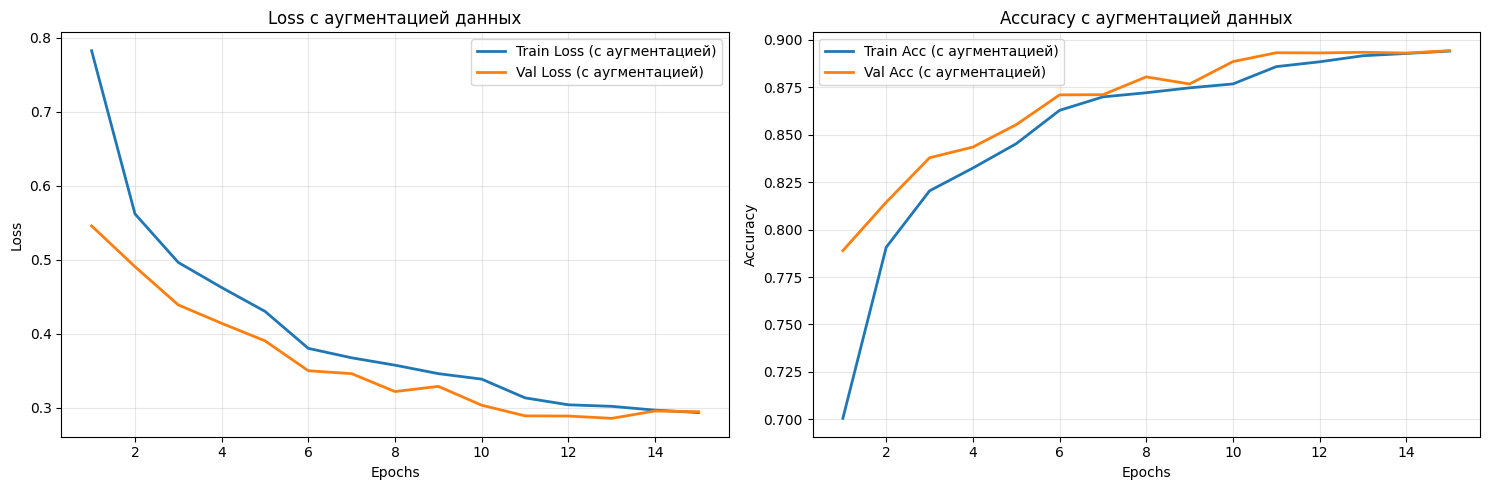

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), aug_train_losses, label='Train Loss (с аугментацией)', linewidth=2)
plt.plot(range(1, num_epochs+1), aug_val_losses, label='Val Loss (с аугментацией)', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss с аугментацией данных')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), aug_train_accs, label='Train Acc (с аугментацией)', linewidth=2)
plt.plot(range(1, num_epochs+1), aug_val_accs, label='Val Acc (с аугментацией)', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy с аугментацией данных')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Итоги могли быть чуть хуже, чем у других моделей из-за StepLR, который замедлил обучение, но проблема переобучения значительно снизилась благодаря аугментации.

По идее, график должен быть плавнее, чем у предыдущих моделей из-за более стабильных градиентов, но из-за малого количества эпох это не особо заметно

# Задание 4

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.skip_connection = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.skip_connection = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1,
                  stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
      )

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    identity = self.skip_connection(identity)
    out += identity
    out = self.relu(out)

    return out

In [ ]:
class FashionMNIST_ResNet(nn.Module):
  def __init__(self, num_classes=10):
    super(FashionMNIST_ResNet, self).__init__()

    self.initial = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

    self.layer1 = self._make_layer(64, 64, 2, stride=1)
    self.layer2 = self._make_layer(64, 128, 2, stride=2)
    self.layer3 = self._make_layer(128, 256, 2, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(256, num_classes)

    self._initialize_weights()

  def _make_layer(self, in_channels, out_channels, blocks, stride):
    layers = []
    layers.append(ResidualBlock(in_channels, out_channels, stride))

    for _ in range(1, blocks):
      layers.append(ResidualBlock(out_channels, out_channels))

    return nn.Sequential(*layers)

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

  def forward(self, x):
    x = self.initial(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.avgpool(x)

    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

model_resnet = FashionMNIST_ResNet().to(device)
print("ResNet архитектура с Skip-Connections:")
print(model_resnet)

ResNet архитектура с Skip-Connections:
FashionMNIST_ResNet(
  (initial): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_connection): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1

In [ ]:
summary(model_resnet, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,136
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
    ResidualBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:
model_resnet_final = FashionMNIST_ResNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet_final.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

resnet_train_losses, resnet_val_losses = [], []
resnet_train_accs, resnet_val_accs = [], []

num_epochs = 15
print("начало обучения...")

for epoch in range(num_epochs):
  train_loss, train_acc = train_epoch(model_resnet_final, train_loader_aug, criterion, optimizer, device)
  val_loss, val_acc = validate(model_resnet_final, val_loader_aug, criterion, device)

  scheduler.step()
  current_lr = optimizer.param_groups[0]['lr']

  resnet_train_losses.append(train_loss)
  resnet_train_accs.append(train_acc)
  resnet_val_losses.append(val_loss)
  resnet_val_accs.append(val_acc)

  print(f'Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

начало обучения...
Epoch [1/15], LR: 0.001000, Train Loss: 0.6040, Train Acc: 0.7746, Val Loss: 0.4646, Val Acc: 0.8223
Epoch [2/15], LR: 0.001000, Train Loss: 0.4599, Train Acc: 0.8269, Val Loss: 0.4238, Val Acc: 0.8398
Epoch [3/15], LR: 0.001000, Train Loss: 0.4103, Train Acc: 0.8475, Val Loss: 0.4220, Val Acc: 0.8420
Epoch [4/15], LR: 0.001000, Train Loss: 0.3809, Train Acc: 0.8561, Val Loss: 0.3984, Val Acc: 0.8513
Epoch [5/15], LR: 0.001000, Train Loss: 0.3662, Train Acc: 0.8616, Val Loss: 0.4079, Val Acc: 0.8447
Epoch [6/15], LR: 0.001000, Train Loss: 0.3531, Train Acc: 0.8698, Val Loss: 0.3613, Val Acc: 0.8600
Epoch [7/15], LR: 0.001000, Train Loss: 0.3418, Train Acc: 0.8719, Val Loss: 0.3307, Val Acc: 0.8775
Epoch [8/15], LR: 0.000500, Train Loss: 0.3292, Train Acc: 0.8774, Val Loss: 0.3875, Val Acc: 0.8533
Epoch [9/15], LR: 0.000500, Train Loss: 0.2888, Train Acc: 0.8918, Val Loss: 0.3072, Val Acc: 0.8821
Epoch [10/15], LR: 0.000500, Train Loss: 0.2796, Train Acc: 0.8950, Val 

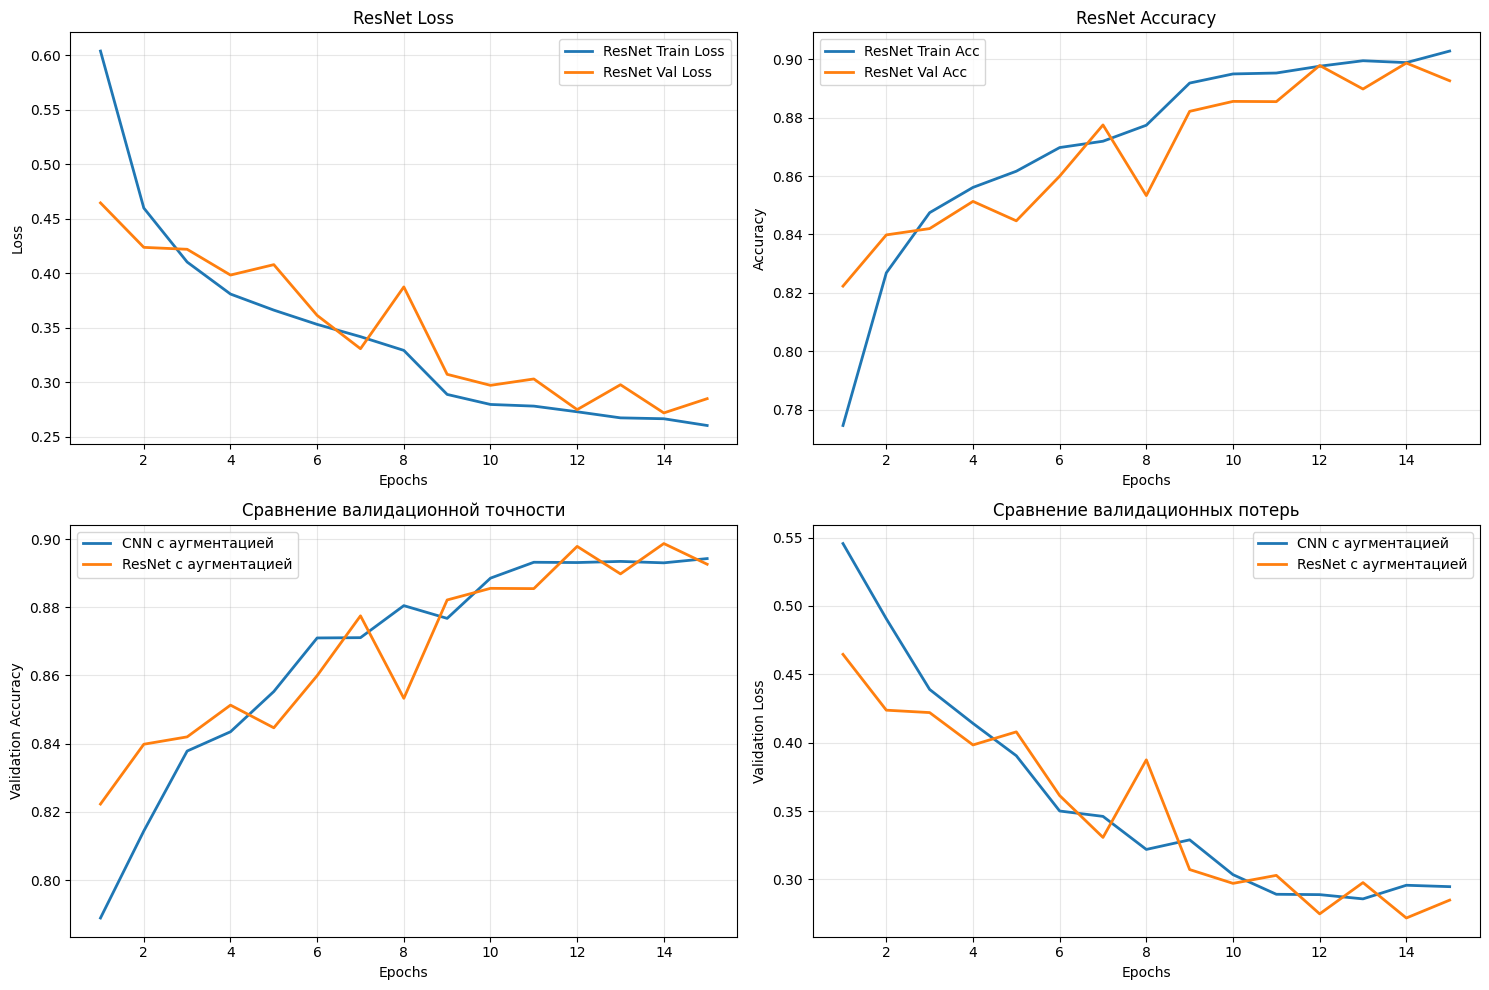

In [ ]:
plt.figure(figsize=(15, 10))

# Графики для ResNet
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs+1), resnet_train_losses, label='ResNet Train Loss', linewidth=2)
plt.plot(range(1, num_epochs+1), resnet_val_losses, label='ResNet Val Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet Loss')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs+1), resnet_train_accs, label='ResNet Train Acc', linewidth=2)
plt.plot(range(1, num_epochs+1), resnet_val_accs, label='ResNet Val Acc', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet Accuracy')
plt.grid(True, alpha=0.3)

# Сравнение с предыдущей моделью
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs+1), aug_val_accs, label='CNN с аугментацией', linewidth=2)
plt.plot(range(1, num_epochs+1), resnet_val_accs, label='ResNet с аугментацией', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Сравнение валидационной точности')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs+1), aug_val_losses, label='CNN с аугментацией', linewidth=2)
plt.plot(range(1, num_epochs+1), resnet_val_losses, label='ResNet с аугментацией', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Сравнение валидационных потерь')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ResNet достигает хороших результатов на первых эпохах быстрее.

Хорошая устойчивость к изменению learning rate.

В целом, визуально, на этом примере не особо заметно большую разницу между моделями